#### Imports...

In [4]:
import numpy as np
import matplotlib.pyplot as plt
#from sklearn import datasets
#from sklearn.decomposition import PCA
import pandas as pd
#from sklearn.preprocessing import StandardScaler
#from bioinfokit.analys import get_data
#from bioinfokit.visuz import cluster
import warnings
warnings.filterwarnings("ignore")


In [5]:
df= pd.read_csv (r'../europe.csv')
df.head(3)

,Country,Area,GDP,Inflation,Life.expect,Military,Pop.growth,Unemployment
0,Austria,83871,41600,3.5,79.91,0.8,0.03,4.2
1,Belgium,30528,37800,3.5,79.65,1.3,0.06,7.2
2,Bulgaria,110879,13800,4.2,73.84,2.6,-0.80,9.6


In [6]:
#Estandarizo los datos
df_countries= df["Country"]
df_stand=  StandardScaler().fit_transform(df[["Area", "GDP", "Inflation", "Life.expect", "Military", "Pop.growth", "Unemployment"]])
df_stand= pd.DataFrame(df_stand, columns=df[["Area", "GDP", "Inflation", "Life.expect", "Military", "Pop.growth", "Unemployment"]].columns)
df_stand.head(3)

,Area,GDP,Inflation,Life.expect,Military,Pop.growth,Unemployment
0,-0.507835,0.683900,0.114447,0.570778,-1.024347,-0.176789,-1.245527
1,-0.835987,0.417061,0.114447,0.487756,-0.388952,-0.115927,-0.592442
2,-0.341689,-1.268238,0.624255,-1.367473,1.263074,-1.860631,-0.069973


### Variables

In [146]:
k = 3
n = 7
radius = 100
learning_rate = 0.7

In [8]:
#example
weights = [[i+j*k for i in range(k)] for j in range(k)]
#starts weights with values from 0 to k*k, like this:
#[[0, 1, 2],
# [3, 4, 5],
# [6, 7, 8]]

weights

[[0, 1, 2], [3, 4, 5], [6, 7, 8]]

```reloading our functions...```

In [40]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
%autoreload 2


what are neighbors?

In [46]:
from utils import get_avg_distance, get_neighbors_avg_dst, get_neighbors
test_mat = [ [[0, 0],[0,1],[0,2],[0,3]],[[1,0],[1,1],[1,2],[1,3]],[[2,0],[2,1],[2,2],[2,3]], [[3,0],[3,1],[3,2],[3,3]]]
for i in range(4):
    for j in range(4):
        print(test_mat[i][j], end=" ")
    print('\n')

print(get_neighbors(test_mat, 1,1))
print(get_neighbors_avg_dst(1,1, test_mat))
print(get_avg_distance(test_mat))

[0, 0] [0, 1] [0, 2] [0, 3] 

[1, 0] [1, 1] [1, 2] [1, 3] 

[2, 0] [2, 1] [2, 2] [2, 3] 

[3, 0] [3, 1] [3, 2] [3, 3] 

[(0, 1), (2, 1), (1, 0), (1, 2)]
1.0
1.0


### `the loop`

<IPython.core.display.Javascript object>


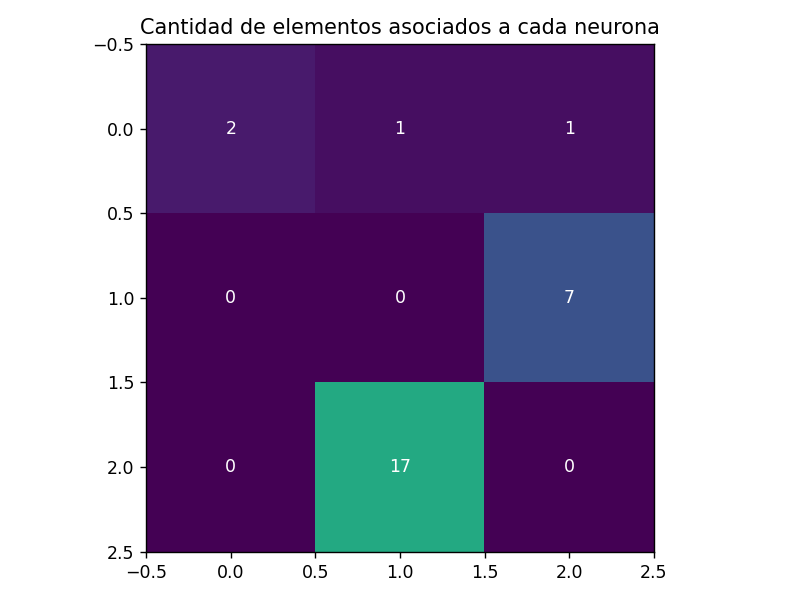

Distancia promedio entre neuronas vecinas (iter final): 0.13628612308327334
[[2, 1, 1], [0, 0, 7], [0, 17, 0]]
100
1.0 0.0 100 0.7


In [158]:
from utils import init_weights, init_weights_from_data, get_winner_neuron, get_active_neurons, update_weights, get_avg_distance
import matplotlib.pyplot as plt

epochs = 100
data_count = len(df_stand.index)
max_t = epochs * data_count
t = 0

w = init_weights_from_data(k, n, df_stand, data_count)


#plotting array
points = np.array([[0 for i in range(k)] for j in range(k)])

free_points = []

#vars
lr = learning_rate
r = radius


for e in range(epochs):
    points = [[0 for i in range(k)] for j in range(k)]
    
    for p in range(data_count):
        #get sample from data
        x_p = df_stand.iloc[[p]][["Area", "GDP", "Inflation", "Life.expect", "Military", "Pop.growth", "Unemployment"]].to_numpy()

        #find winner neuron
        closest_info = get_winner_neuron(w, x_p, k)

        points[closest_info['x']][ closest_info['y']] += 1

        #neuronas activadas
        N_k = get_active_neurons(w, k, closest_info['x'], closest_info['y'], r)

        #actualizar pesos
        w = update_weights(w, x_p, N_k, lr)

        #update radius and learning_rate
        r = np.floor((max_t - t*1.2) * r/max_t) + 1
        lr = lr/(t+1)
        t += 1
    
    free_points.append(points)

#plotting the final heatmap...
fig1, ax = plt.subplots()
im = ax.imshow(points, vmin=0, vmax=28)
# Loop over data dimensions and create text annotations.
for i in range(k):
    for j in range(k):
        if points[i][j] <= 20: 
            text = ax.text(j, i, points[i][j], ha="center", va="center", color="w")
        else:
            text = ax.text(j, i, points[i][j], ha="center", va="center", color="b")

ax.set_title("Cantidad de elementos asociados a cada neurona")
fig1.tight_layout()
plt.show()


#calculate avg neighbors distance for final iter...
print("Distancia promedio entre neuronas vecinas (iter final):", get_avg_distance(w))
print(points)
print(len(free_points))
print(r, lr, radius, learning_rate)


### code refactor!

In [204]:
from som import Params, SOM

params = Params(k=3,n=7,r=10, lr=0.8)
som = SOM(params, data=df_stand, epochs=50)
res = som.run()

print(len(res['heatmaps']))
print(res['averages'][len(res['averages']) - 1])
#print(res['heatmaps'][len(res['heatmaps']) - 1])
for i in range(len(res['heatmaps'])):
    print(res['heatmaps'][i])



[[array([-1.00787904,  3.42251157,  0.04161702,  0.51968762, -0.89726824,
        2.07509647, -0.91898462]), array([-0.62645298, -1.05757539,  0.76991493, -1.65805098, -0.64311032,
       -1.45488607,  0.6266511 ]), array([-0.74555673, -0.80478051,  1.20689367, -1.45049525,  0.50060034,
       -1.55632235,  0.56134255])], [array([ 2.08511516, -0.09555044, -0.17687235,  1.00504872, -0.51603135,
        1.08102092,  2.56413813]), array([ 2.08511516, -0.09555044, -0.17687235,  1.00504872, -0.51603135,
        1.08102092,  2.56413813]), array([-0.5386185 , -0.33430116, -1.05082984, -0.23709251, -0.57957083,
       -0.50138504, -0.30943814])], [array([ 1.74630832,  0.6207017 , -0.24970214,  0.97631023, -0.13479447,
        0.10723264, -0.52713331]), array([-0.75868454,  0.36088475, -0.39536172,  0.20995061, -0.38895239,
        0.24924343, -0.83190655]), array([-0.67563611, -0.97331043, -0.75951067, -0.68094246,  0.99620829,
       -0.42023602,  1.69335744])]]
0.8
0.8001600160010668
0.80032

0.8744645250610642
0.8746394354565329
0.8748143808375792
0.8749893612112007
0.8751643765843969
0.8753394269641683
0.8755145123575169
0.875689632771446
0.8758647882129607
0.8760399786890668
0.8762152042067725
0.8763904647730861
0.8765657603950188
0.8767410910795816
0.8769164568337884
0.8770918576646536
0.8772672935791932
0.8774427645844247
0.8776182706873668
0.8777938118950399
0.8779693882144657
0.878144999652667
0.8783206462166684
0.8784963279134959
0.8786720447501765
0.8788477967337389
0.8790235838712136
0.8791994061696315
0.8793752636360259
0.8795511562774311
0.8797270841008823
0.8799030471134173
0.8800790453220743
0.8802550787338931
0.8804311473559152
0.8806072511951831
0.8807833902587414
0.8809595645536353
0.881135774086912
0.8813120188656198
0.8814882988968086
0.8816646141875293
0.8818409647448346
0.8820173505757787
0.882193771687417
0.8823702280868062
0.8825467197810047
0.882723246777072
0.8828998090820694
0.8830764067030593
0.8832530396471056
0.8834297079212736
0.883606411532629

0.9573908575529452
0.9575823548735495
0.9577738904974482
0.9579654644323026
0.9581570766857758
0.9583487272655319
0.9585404161792375
0.9587321434345597
0.9589239090391679
0.9591157130007325
0.9593075553269259
0.9594994360254214
0.9596913551038947
0.9598833125700224
0.9600753084314824
0.960267342695955
0.9604594153711216
0.9606515264646647
0.9608436759842691
0.9610358639376207
0.9612280903324069
0.9614203551763169
0.9616126584770411
0.961805000242272
0.961997380479703
0.9621897991970292
0.9623822564019475
0.9625747521021563
0.9627672863053554
0.9629598590192459
0.963152470251531
0.9633451200099149
0.9635378083021039
0.9637305351358052
0.9639233005187281
0.9641161044585831
0.9643089469630826
0.9645018280399399
0.9646947476968704
0.9648877059415911
0.9650807027818202
0.9652737382252774
0.9654668122796842
0.9656599249527638
0.9658530762522406
0.9660462661858404
0.966239494761291
0.9664327619863216
0.9666260678686627
0.9668194124160467
0.9670127956362073
0.9672062175368797
0.967399678125801

1.0498596081286689
1.0500696010488866
1.0502796359718887
1.0504897129060762
1.0506998318598524
1.050909992841622
1.0511201958597913
1.0513304409227688
1.0515407280389641
1.0517510572167885
1.0519614284646555
1.0521718417909796
1.0523822972041776
1.0525927947126676
1.0528033343248697
1.0530139160492051
1.0532245398940974
1.0534352058679715
1.0536459139792538
1.053856664236373
1.0540674566477584
1.0542782912218427
1.0544891679670587
1.0547000868918415
1.054911048004628
1.0551220513138564
1.055333096827967
1.0555441845554019
1.0557553145046041
1.055966486684019
1.0561777011020936
1.0563889577672763
1.0566002566880177
1.0568115978727692
1.057022981329985
1.0572344070681199
1.0574458750956315
1.057657385420978
1.0578689380526203
1.0580805329990202
1.0582921702686414
[[array([ 0.33412404,  0.45412047,  0.675208  ,  0.87912302,  1.48426735,
        1.02806287, -0.39788152]), array([ 0.33412404,  0.45412047,  0.675208  ,  0.87912302,  1.48426735,
        1.02806287, -0.39788152]), array([ 0.33

### trying to show an animation in jupyter notebook (not in VSCode)

#### required for animations

In [14]:
%matplotlib notebook

#### heatmap animation (doesn't work in VSCode at least...)

<IPython.core.display.Javascript object>


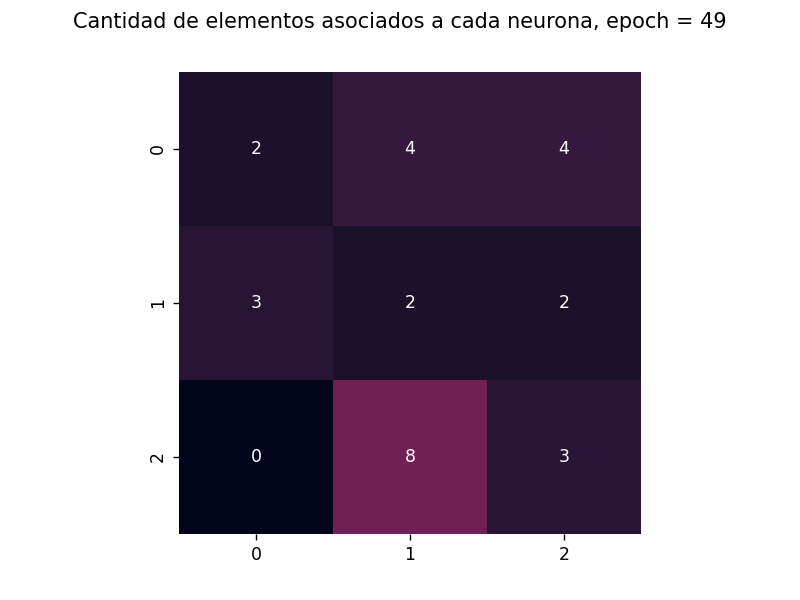

we are done here


In [195]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import animation

fig2 = plt.figure()
fig2.tight_layout()

my_heats = res['heatmaps']
#my_heats = free_points

#data = np.random.rand(10, 10)
#sns.heatmap(data, vmax=.8, square=True)
#labels = (np.asarray(["{1:.3f}".format(value) for value in my_heats[0]])).reshape(params.k, params.k)
labels= my_heats[0]
#sns.heatmap(my_heats[0], annot=labels)
sns.heatmap(my_heats[0])

def init():
    #sns.heatmap(np.zeros((10, 10)), vmax=.8, square=True, cbar=False)
    #labels= my_heats[0]
    #sns.heatmap(my_heats[0], annot=labels, vmax=28, square=True, cbar=False)
    sns.heatmap(my_heats[0], vmax=28, square=True, cbar=False)

def animate(i):
    #data = np.random.rand(10, 10)
    frame_data = my_heats[i]
    print(str(i))
    #sns.heatmap(data, vmax=.8, square=True, cbar=False)
    #labels = (np.asarray(["{1:.3f}".format( value) for value in frame_data])).reshape(params.k, params.k)
    plt.clf()
    fig2.suptitle("Cantidad de elementos asociados a cada neurona, epoch = " + str(i))
    #CURRENT ISSUE: labels don't get cleaned on draw()/animate(), so they step over each other on every redraw
    labels = frame_data
    sns.heatmap(frame_data, annot=True, vmax=28, square=True, cbar=False)

#anim = animation.FuncAnimation(fig, animate, init_func=init, frames=20, repeat = False)
anim = animation.FuncAnimation(fig2, animate, init_func=init, frames=len(my_heats), interval = 200, repeat = False)

print('we are done here')
#anim.save("TEST.gif", dpi=300, writer= animation.PillowWriter(fps=5))

<IPython.core.display.Javascript object>


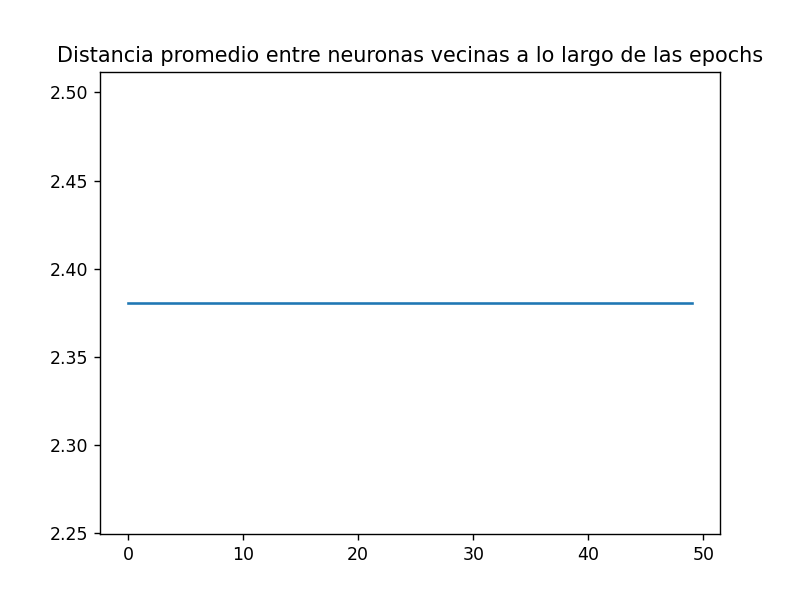

In [188]:
import matplotlib.pyplot as plt
fig3 = plt.figure()
fig3.tight_layout()
plt.plot(res['averages'], color='tab:blue')
plt.title("Distancia promedio entre neuronas vecinas a lo largo de las epochs")
plt.show()